# Propose d
### Data size : 24 x 24

### Mounting drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Libraries

In [0]:
import os
#import cv2
import time # for time spend callbacks
import pickle
import statistics # mean report time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, Callback
from keras.layers import Input, Conv2D, MaxPool2D, Activation, Dropout, Dense, \
                        concatenate, AveragePooling2D, GlobalAveragePooling2D, \
                        Flatten, BatchNormalization
from keras.optimizers import SGD
from keras.initializers import glorot_uniform, Constant

Using TensorFlow backend.


### Dictionaries

In [0]:
path_dict = {
    'colab':("drive/My Drive/Colab Notebooks/dataset/80-20/80-20-24-no-aug-in-test.pkl",
             "drive/My Drive/Colab Notebooks"),
    'ultrabook':("../../data/extraction/2-release/samples-ext/samples-train-test-24-2-class.pkl",
            "../../warehouse")
}

optimizer_dict = {
    'adam' : 'adam',
    'SGD' : 'SGD',
    'SGD_param' : SGD(lr=1e-2, momentum=0.9, nesterov=False)
}

init_dict = {
    'kernel' : glorot_uniform(),
    'bias' : Constant(value = 0.2)
}

## Hyperparameter

In [0]:
class HyperParameter:
    def __init__(self):
        self._path_pickle, self._path_save = path_dict['colab']
        
        self._name = "127"
        self._img_size = 24
        self._running_numbers = 6
        
        self._epochs = 50
        self._batchs = 128
        self._optimizer = optimizer_dict['adam']
        
        print('HyperParameter set')

if __name__=='__main__':
    hp = HyperParameter()

HyperParameter set


## Load Data

In [0]:
class LoadData(HyperParameter):
    
    def loading_img(self, path_data):
        print(f'[INFO] Load char {path_name}')
        
        path_name = os.path.basename(path_data)
        loaded_images = []
        loaded_labels = []
        
        self.__class_labels = sorted(os.listdir(path_data)) # Label
        self.__number_of_class = len(self.__class_labels) # Amount

        for class_label in tqdm(self.__class_labels):
            class_index = self.__class_labels.index(class_label) # Get index
            path_img = os.path.join(path_data, class_label)

            for img_name in os.listdir(path_img):
                img = cv2.imread(
                    os.path.join(path_img, img_name), cv2.IMREAD_GRAYSCALE) # Grayscale
                loaded_images.append(img)
                loaded_labels.append(class_index)
                
        print(f'jumlah data : {len(loaded_images)} data')

        return loaded_images, loaded_labels

    def executing_load(self):
        """Load characters from directories"""
        
        self.__x_train, self.__y_train = self.loading_img(self._path_train)
        self.__x_val, self.__y_val = self.loading_img(self._path_val)
        
        print(f'\nClass : {self.__class_labels}')
        print(f'\nNumber of class : {self.__number_of_class} class')
        
    def loading_pickle(self):
        """Load character from pickle file"""
        
        path_pickle = self._path_pickle
        
        p_in = open(path_pickle, "rb")
        loaded_pickle = pickle.load(p_in)
        p_in.close()
        
        self.__x_train = loaded_pickle[0]
        self.__y_train = loaded_pickle[1]
        self.__x_test = loaded_pickle[2]
        self.__y_test = loaded_pickle[3]
        self.__number_of_class = loaded_pickle[4]
        self.__class_labels = loaded_pickle[5]
        
        print(f'jumlah data train : {len(self.__x_train)} gambar dan {len(self.__y_train)} label')
        print(f'jumlah data val : {len(self.__x_test)} gambar dan {len(self.__y_test)} label')
        print(f'jumlah class : {self.__number_of_class}')
        print(f'class : {self.__class_labels}')
        
    @property
    def x_train(self):
        return self.__x_train
    @property
    def y_train(self):
        return self.__y_train
    @property
    def x_test(self):
        return self.__x_test
    @property
    def y_test(self):
        return self.__y_test
    @property
    def number_of_class(self):
        return self.__number_of_class
    @property
    def classes(self):
        return self.__class_labels
    
load = LoadData()
#load.executing_load()
load.loading_pickle()

HyperParameter set
jumlah data train : 14400 gambar dan 14400 label
jumlah data val : 3600 gambar dan 3600 label
jumlah class : 36
class : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### Train and Test samples

train label 18, shape (24, 24)
test label 16, shape (24, 24)


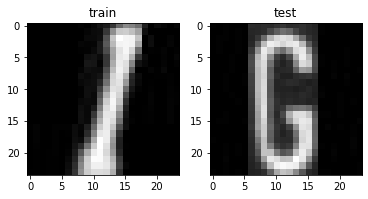

In [0]:
index = 3
print('train label {}, shape {}'.format(load.y_train[index], load.x_train[index].shape))
print('test label {}, shape {}'.format(load.y_test[index], load.x_test[index].shape))

plt.subplot(121), plt.imshow(load.x_train[index], 'gray'), plt.title('train')
plt.subplot(122), plt.imshow(load.x_test[index], 'gray'), plt.title('test')
plt.show()

## Preprocessing

In [0]:
class Preprocessing(HyperParameter):
    def __init__(self, x_train, y_train, x_test, y_test, num_class):
        HyperParameter.__init__(self)
        self.__x_train = x_train
        self.__y_train = y_train
        self.__x_test = x_test
        self.__y_test = y_test
        self.__num_class = num_class

    def reshape_normalize(self, x):
        x = np.array(x).reshape(-1, self._img_size, self._img_size, 1)
        x = x.astype('float32')
        x /= 255
        
        return x
    
    def collecting_shape(self, feature):
        feature_shape = feature[0].shape # shape
        print('image shape {}'.format(feature_shape))
        
        return feature_shape
    
    def binary_class_matrix(self, y, number_class):
        y = to_categorical(y, number_class)
        
        print('class binnerization succeed')
        
        return y
    
    def get_reshape_matrix(self):
        print('[INFO] Preprocessing: reshape, normalize, binary_class_matrix...')
        
        self.__x_train_reshape = self.reshape_normalize(self.__x_train)
        self.__y_train_reshape = self.binary_class_matrix(self.__y_train, self.__num_class)
        
        print('feature train shape {}'.format(self.__x_train_reshape.shape))
        
        self.__x_test_reshape = self.reshape_normalize(self.__x_test)
        self.__y_test_reshape = self.binary_class_matrix(self.__y_test, self.__num_class)
        
        print('feature test shape {}'.format(self.__x_test_reshape.shape))
        
        self.__image_shape = self.collecting_shape(self.__x_test_reshape)
        
        print('preprocessing done')
        
    @property
    def x_train(self):
        return self.__x_train_reshape
    @property
    def y_train(self):
        return self.__y_train_reshape
    @property
    def x_test(self):
        return self.__x_test_reshape
    @property
    def y_test(self):
        return self.__y_test_reshape
    @property
    def image_shape(self):
        return self.__image_shape
    
pp = Preprocessing(load.x_train, load.y_train,
                       load.x_test, load.y_test,
                       load.number_of_class)
pp.get_reshape_matrix()

HyperParameter set
[INFO] Preprocessing: reshape, normalize, binary_class_matrix...
class binnerization succeed
feature train shape (14400, 24, 24, 1)
class binnerization succeed
feature test shape (3600, 24, 24, 1)
image shape (24, 24, 1)
preprocessing done


## Time Counter

In [0]:
class TimeHistory(Callback):
    def on_train_begin(self, logs = {}):
        self.times = []
    def on_epoch_begin(self, batch, logs = {}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs = {}):
        self.times.append(time.time() - self.epoch_time_start)

## Model

In [0]:
class ConvolutionalNetworks(HyperParameter):
    def __init__(self, x_train, y_train, x_test, y_test, input_shape, num_classes):
        HyperParameter.__init__(self)
        self.__x_train = x_train
        self.__y_train = y_train
        self.__x_test = x_test
        self.__y_test = y_test
        self.__num_classes = num_classes
        self.X_input = Input(shape=input_shape)

        self._results = []
        self._average_acc = []

    def setting_path(self):
        path_save = os.path.join(self._path_save, self._name)
        if not os.path.exists(path_save):
            os.mkdir(path_save)

        self._path_logs = os.path.join(path_save, "logs")
        self._path_model = os.path.join(path_save, "models")
        self._path_history = os.path.join(path_save, "histories")
        self._path_recordings = os.path.join(path_save, "recordings")

        path_list = [self._path_logs,
                     self._path_model,
                     self._path_history,
                     self._path_recordings]
        
        for path in path_list:
            if not os.path.exists(path):
                os.mkdir(path)
                print(f'Path {path} created')

    def saving_results(self, model, histories, recordings, name):
        model.save(os.path.join(self._path_model, "m-{}.h5".format(name)))

        p_out = open(os.path.join(self._path_history, "h-{}.pkl".format(name)), "wb")
        pickle.dump(histories, p_out)
        p_out.close()

        p_out = open(os.path.join(self._path_recordings, "r-{}.pkl".format(name)), "wb")
        pickle.dump(recordings, p_out)
        p_out.close()

        print(f'{name} saved\n')
        
    def conv(self, X, filter_numbers, filter_size, strides, paddings):
        X = Conv2D(filter_numbers, (filter_size, filter_size), strides=strides, padding=paddings)(X)
        
        return X
    
    def conv_bn(self, X, filter_numbers, filter_size, strides, paddings):
        X = Conv2D(filter_numbers, (filter_size, filter_size), strides=strides, padding=paddings)(X)
        X = BatchNormalization()(X)
        
        return X
    
    def conv_act(self, X, filter_numbers, filter_size, strides, paddings):
        X = Conv2D(filter_numbers, (filter_size, filter_size), strides=strides, padding=paddings)(X)
        X = Activation('relu')(X)
        
        return X

    def conv__bn_act(self, X, filter_numbers, filter_size, strides, paddings):
        X = Conv2D(filter_numbers, (filter_size, filter_size), strides=strides, padding=paddings)(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        return X
    
    def res_conv_block(self, X, filters, filter_size, strides, paddings=None):
        X_shortcut = X
        
        X = self.conv_bn(X, filters, filter_size, strides, paddings)
        X = self.conv_bn(X, filters, filter_size, 1, paddings)
        
        X_shortcut = self.conv(X_shortcut, filters, 1, strides, paddings)
        
        merged = Add()([X, X_shortcut])
        
        return merged
    
    def res_idn_block(self, X, filters, filter_size, strides, paddings=None):
        X_shortcut = X
        
        X = self.conv_bn(X, filters, filter_size, strides, paddings)
        X = self.conv_bn(X, filters, filter_size, strides, paddings)
        
        merged = Add()([X, X_shortcut])
        
        return merged
    
    def wide_conv_block(self, X, filter_numbers, filter_size, strides, paddings):
        X_shortcut = X
        
        X = self.conv_act(X, filter_numbers, filter_size, strides, paddings)
        X = self.conv_act(X, filter_numbers, filter_size, 1, paddings)

        X_shortcut = self.conv(X_shortcut, filter_numbers, filter_size, strides, paddings)

        merged = Add()([X, X_shortcut])
        
        return merged
    
    def wide_idn_block(self, X, filter_numbers, filter_size, strides, paddings):
        X_shortcut = X
        
        #X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = self.conv_act(X, filter_numbers, filter_size, strides, paddings)
        X = self.conv(X, filter_numbers, filter_size, strides, paddings)
        
        merged = Add()([X, X_shortcut])
        
        return merged
    
    def incept_v1(self, X, filter_numbers, filter_size, strides, paddings):
        conv_1x1 = self.conv_act(X, 64, 1, strides, paddings)
        
        conv_3x3 = self.conv_act(X, 64, 1, strides, paddings)
        conv_3x3 = self.conv_act(conv_3x3, 96, 3, strides, paddings)
        
        conv_2x3x3 = self.conv_act(X, 16, 1, strides, paddings)
        conv_2x3x3 = self.conv_act(conv_2x3x3, 48, 3, strides, paddings)
        conv_2x3x3 = self.conv_act(conv_2x3x3, 48, 3, strides, paddings)
        
        pool_3x3 = MaxPool2D((3, 3), strides=(strides, strides), padding=paddings)(X)
        pool_3x3 = self.conv_act(pool_3x3, 32, 1, strides, paddings)
        
        concat = concatenate([conv_1x1, conv_3x3, conv_2x3x3, pool_3x3], axis=3)
        
        return concat
    
    def incept_conv_max(self, X, filter_numbers, filter_size, strides, paddings):
        X_conv = self.conv_act(X, filter_numbers, filter_size, strides, paddings)

        X_pool = MaxPool2D((filter_size, filter_size), strides=strides, padding=paddings)(X)
        
        concat = concatenate([X_conv, X_pool], axis=3)

        return concat
    
    def running_architecture(self):
        filter_numbers = (32, 64, 128, 256)
        dropout_numbers = np.round(np.arange(0.1, 1, 0.1), decimals=1)

        snippet_name = "max-2"

        for number in range(self._running_numbers):
            save_name = f"{self._name}-{snippet_name}-{number}-{int(time.time())}"
        
            X = self.conv_act(self.X_input, filter_numbers[0], 3, 1, 'same')
            X = self.incept_conv_max(X, filter_numbers[0], 3, 1, 'valid')

            #X = self.conv_act(X, filter_numbers[1], 3, 1, 'same')
            X = self.incept_v1(X, 16, 3, 1, 'same')
            X = self.incept_conv_max(X, filter_numbers[1], 3, 2, 'valid')

            X = self.conv_act(X, filter_numbers[2], 3, 1, 'same')
            X = self.conv_act(X, filter_numbers[2], 3, 1, 'same')
            X = MaxPool2D((3, 3), strides=(2, 2))(X)
            
            X = self.conv_act(X, filter_numbers[3], 3, 1, 'same')
            X = self.conv_act(X, filter_numbers[3], 3, 1, 'same')
            X = MaxPool2D((3, 3), strides=(1, 1), padding='valid')(X)
            
            X = GlobalAveragePooling2D()(X)

            X = Dense(1024, name='fc')(X)
            X = Activation('relu', name='fc_relu')(X)
            X = Dropout(0.5, name='dropout')(X)

            X = Dense(self.__num_classes, activation='softmax', name='softmax')(X)

            model = Model(inputs = self.X_input,
                          outputs = X,
                          name = save_name)
            model.summary()
            model.compile(
                loss='categorical_crossentropy',
                optimizer=self._optimizer,
                metrics=['accuracy'])

            time_callback = TimeHistory()
            tensorboard = TensorBoard(log_dir=os.path.join(self._path_logs, "{}".format(save_name)))

            histories = model.fit(
                self.__x_train, self.__y_train,
                validation_data = (self.__x_test, self.__y_test),
                epochs = self._epochs,
                batch_size = self._batchs,
                verbose = 2,
                callbacks = [time_callback, tensorboard])

            recordings = time_callback.times

            test_score = model.evaluate(pp.x_test, pp.y_test)        
            show_score = "Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], (test_score[1]) * 100)
            print(show_score)

            total_time = sum(recordings) # Detik
            menit_time = total_time/60
            recorded_mean = statistics.mean(recordings)
            
            print(f'\nTotal in second = {round(total_time, 3)} seconds')
            print(f'Total in minute = {round(menit_time, 3)} minutes')
            train_speed = f'Time = {round(recorded_mean, 3)} second/epochs'
            print(train_speed)
            print()

            #self.saving_results(model, histories, recordings, save_name)

            self._results.append([save_name, show_score, train_speed])
            self._average_acc.append([test_score[1]])

    def reporting_results(self):
        for report in self._results:
            print(report)

        print()
        self._average_acc = np.round(np.mean(self._average_acc), 2)
        
    def showing_graph(self):
        if keras.__version__=='2.3.1':
            format_hist = ['accuracy', 'val_accuracy']
        else:
            format_hist = ['acc', 'val_acc']
        
        f, ax = plt.subplots() # Accuracy Graph
        ax.plot([None] + self.__history.history[format_hist[0]], 'o-')
        ax.plot([None] + self.__history.history[format_hist[1]], 'x-')
        ax.legend(['Akurasi Train', 'Akurasi Validasi'], loc = 0) # loc = 0 => lokasi legend
        ax.set_title('Akurasi dan Validasi per Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Akurasi')
        
        f, ax = plt.subplots() # Loss Graph
        ax.plot([None] + self.__history.history['loss'], 'o-')
        ax.plot([None] + self.__history.history['val_loss'], 'x-')
        ax.legend(['Loss Train', 'Loss Validasi'], loc = 0) # loc = 0 => lokasi legend
        ax.set_title('Loss Train dan Validasi per Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

cnn = ConvolutionalNetworks(pp.x_train, pp.y_train,
                           pp.x_test, pp.y_test,
                           pp.image_shape, load.number_of_class)
cnn.setting_path()
cnn.running_architecture()
cnn.reporting_results()
#cnn.showing_graph()

HyperParameter set
Model: "127-max-2-0-1580359270"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 24, 24, 1)    0                                            
__________________________________________________________________________________________________
conv2d_489 (Conv2D)             (None, 24, 24, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
activation_489 (Activation)     (None, 24, 24, 32)   0           conv2d_489[0][0]                 
__________________________________________________________________________________________________
conv2d_490 (Conv2D)             (None, 22, 22, 32)   9248        activation_489[0][0]             
__________________________________________________________

## Reference
Ignatius Wendianto Notonogoro, Jondri, Anditya Arifianto, "Indonesian License Plate Recognition Using Convolutional Neural Network", IEEE, Int. Conf. IColCT, 2018.